In [1]:
# pip install tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl
from tqdm import tqdm
import time
from scipy.interpolate import CubicSpline
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import brentq
from numba import jit
mpl.rcParams["figure.dpi"] = 240
mpl.rcParams["figure.figsize"] = (10,6)
r,T,strike = 0.01,1,100

In [2]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]   
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

# 2.1.a

$$
\begin{cases}\frac{\partial V}{\partial t}+\frac{\sigma^2(t, s) s^2}{2} \frac{\partial^2 V}{\partial s^2}+r s \frac{\partial V}{\partial s}-r V=0, & t<T \\ V(T, s)=g(s), & t=T\end{cases}
$$
Let $\tau = T-t$, we have 
$$
\begin{cases}\frac{\partial V}{\partial \tau}=\frac{\psi^2(\tau, s) s^2}{2} \frac{\partial^2 V}{\partial s^2}+r s \frac{\partial V}{\partial s}-r V, & \tau<T \\ V(0, s)=g(s), & \tau=0\end{cases}
$$
where $\psi(\tau,s) = \left(1+\frac{T-\tau}{30}\right)\left[0.1+0.4 \exp \left(-\frac{s}{50}\right)\right]$

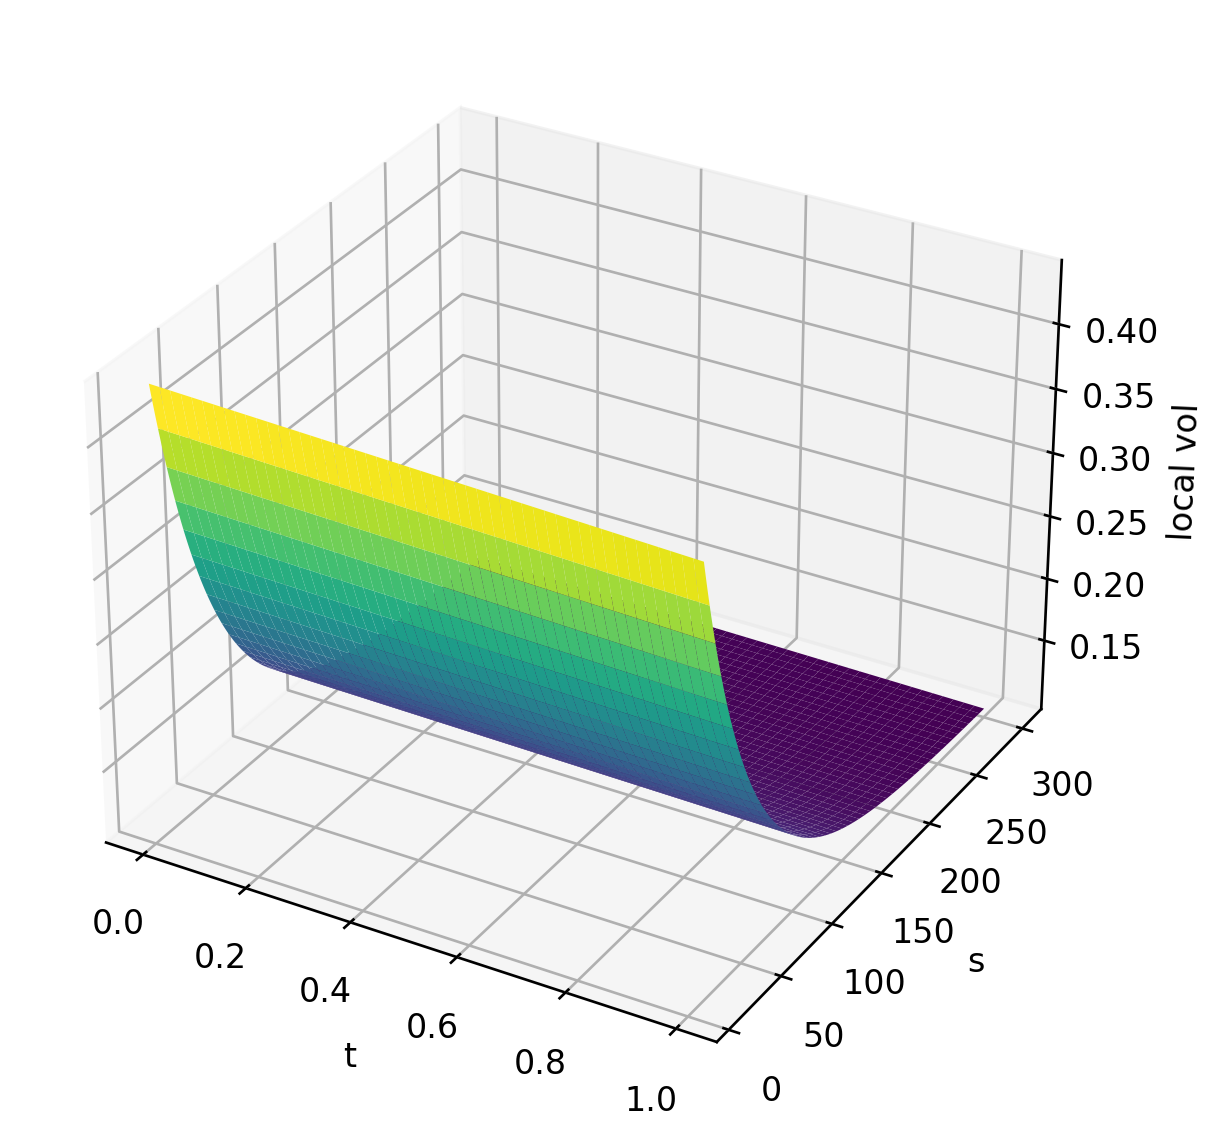

In [3]:
t_ = np.linspace(0, 1, 500)
s_ = np.linspace(10,300, 500)

T_, S_ = np.meshgrid(t_, s_)

Z = (1+ (1-T_)/30) * (0.1+0.4*np.exp(-S_/50))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_, S_, Z, cmap='viridis')
ax.set_xlabel('t')
ax.set_ylabel('s')
ax.set_zlabel('local vol')
plt.show
plt.savefig("./Q2.1.a.jpg")

In [4]:
N = 2000
M = 200 

# 2.1.b

For the call, the boundary condition is 
$$V(\tau,s_{max}) = s_{max} - K  e^{-r\tau}$$
$$V(\tau,s_{min}) = 0$$

## Explicit scheme

$$
A_k^n:=\frac{\Delta \tau}{\Delta x^2} a_k^n-\frac{\Delta \tau}{2 \triangle x} b_k^n, \quad B_k^n:=-\frac{2 \triangle \tau}{\triangle x^2} a_k^n-\triangle \tau c_k^n, \quad C_k^n:=\frac{\Delta \tau}{\Delta x^2} a_k^n+\frac{\triangle \tau}{2 \triangle x} b_k^n
$$

In [5]:
def psi(t,s):
    t,s = np.meshgrid(t,s,indexing='ij') # psi[i,j] = psi(t_i,x_j)
    return (1+ (T-t)/30) * (0.1+0.4*np.exp(-s/50))

def explicit_solver(N,M,r,strike,s_min = 10,s_max = 300):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    sol = np.maximum(s_axis-strike,0)
    
    # define auxiliary function/matrix
    a = 0.5*psi(t_axis,s_axis)**2 * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N,M+1,M+1))
    for i in range(N):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([A[i,j], 1+B[i,j], C[i,j]])
    L[:,0,0],L[:,-1,-1] = 1,1
        
    # solve numerically
    for i in range(N):
        sol = np.matmul(L[i], sol)
        sol[-1] = s_axis[-1] - strike * np.exp(-r*t_axis[i])
        sol[0] = 0
    return sol

In [6]:
explicit = explicit_solver(N,M,r,strike,s_min = 10,s_max = 300)

## Implicit scheme

In [7]:
def implicit_solver(N,M,r,strike,s_min = 10,s_max = 300):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    sol = np.maximum(s_axis-strike,0)
    
    # define auxiliary function/matrix
    a = 0.5*psi(t_axis,s_axis)**2 * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N,M+1,M+1))
    for i in range(N):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([-A[i+1,j], 1-B[i+1,j], -C[i+1,j]])
    L[:,0,0],L[:,-1,-1] = 1,1
        
    # solve numerically
    for i in range(N):
        tmp = sol
        tmp[-1] = s_axis[-1] - strike * np.exp(-r*t_axis[i])
        tmp[0] = 0
        sol = TDMAsolver(np.diag(L[i],k=-1), np.diag(L[i]), np.diag(L[i],k=1),tmp)
    return sol 

In [8]:
implicit = implicit_solver(N,M,r,strike,s_min = 10,s_max = 300)

## Crank-Nicolson scheme

In [9]:
def cn_solver(N,M,r,strike,s_min = 10,s_max = 300):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    sol = np.maximum(s_axis-strike,0)
    
    # define auxiliary function/matrix
    a = 0.5*psi(t_axis,s_axis)**2 * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N+1,M+1,M+1))
    for i in range(N+1):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([A[i,j], B[i,j], C[i,j]])

        
    # solve numerically
    for i in range(1,N+1):
        sol_pre = np.matmul(np.eye(M+1)+0.5*L[i-1],sol)
        sol_pre[-1] = s_axis[-1] - strike * np.exp(-r*t_axis[i])
        sol_pre[0] = 0
        sol = TDMAsolver(np.diag(np.eye(M+1)-0.5*L[i],k=-1), np.diag(np.eye(M+1)-0.5*L[i]), np.diag(np.eye(M+1)-0.5*L[i],k=1),sol_pre)
    return sol   

In [10]:
cn = cn_solver(N,M,r,strike,s_min = 10,s_max = 300)

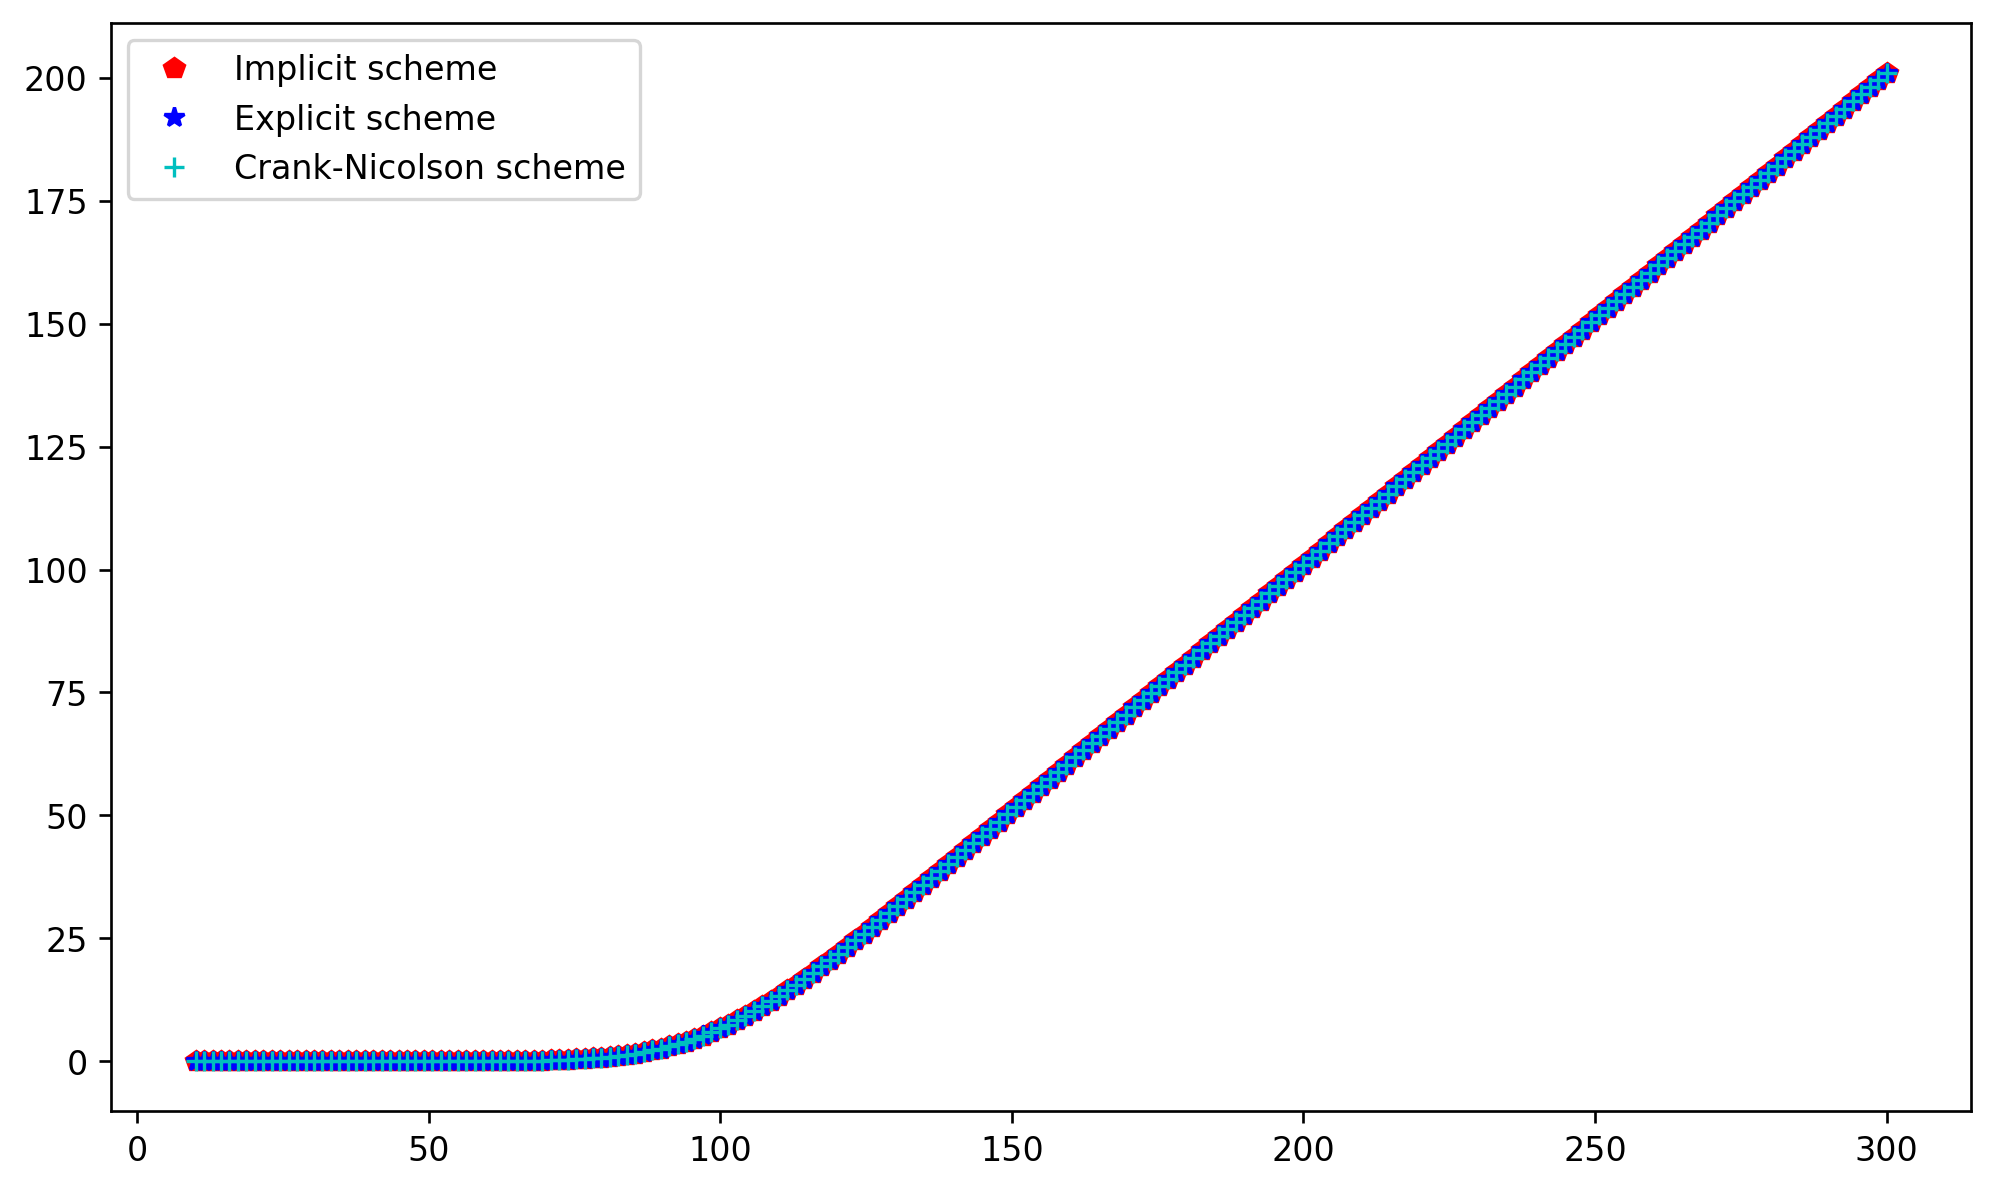

In [11]:
plt.plot(np.linspace(10,300,201),implicit,'rp',label = "Implicit scheme")
plt.plot(np.linspace(10,300,201),explicit,"b*",label = "Explicit scheme")
plt.plot(np.linspace(10,300,201),cn,"c+",label = "Crank-Nicolson scheme")
plt.legend()

# 2.1.c

In [12]:
s_0 = np.arange(80,125,5)
x = np.linspace(10,300,201)

In [13]:
cs_explicit = CubicSpline(x, explicit)
cs_implicit = CubicSpline(x, implicit)
cs_cn = CubicSpline(x, cn)
dic_explicit = [np.round(cs_explicit(i),6) for i in s_0]
dic_implicit = [np.round(cs_implicit(i),6) for i in s_0]
dic_cn = [np.round(cs_cn(i),6) for i in s_0]
dic = {"Explicit scheme":dic_explicit,"Implicit scheme":dic_implicit,"Crank-Nicolson scheme":dic_cn}
data = pd.DataFrame(dic,index = s_0)
data.index.name = "Initial price"
data 

,Explicit scheme,Implicit scheme,Crank-Nicolson scheme
Initial price,,,
80,0.750779,0.751032,0.750906
85,1.474107,1.474072,1.474090
90,2.643789,2.643370,2.643580
95,4.371698,4.370945,4.371321
100,6.725446,6.724551,6.724998
105,9.710965,9.710168,9.710566
110,13.273144,13.272624,13.272884
115,17.313230,17.313038,17.313134
120,21.714387,21.714460,21.714423


In [14]:
print(data.style.to_latex())

\begin{tabular}{lrrr}
 & Explicit scheme & Implicit scheme & Crank-Nicolson scheme \\
Initial price &  &  &  \\
80 & 0.750779 & 0.751032 & 0.750906 \\
85 & 1.474107 & 1.474072 & 1.474090 \\
90 & 2.643789 & 2.643370 & 2.643580 \\
95 & 4.371698 & 4.370945 & 4.371321 \\
100 & 6.725446 & 6.724551 & 6.724998 \\
105 & 9.710965 & 9.710168 & 9.710566 \\
110 & 13.273144 & 13.272624 & 13.272884 \\
115 & 17.313230 & 17.313038 & 17.313134 \\
120 & 21.714387 & 21.714460 & 21.714423 \\
\end{tabular}



# 2.2.a

In [15]:
def BS_price(sigma,price,strike_price,r,T):
    d_positive = (np.log(price/strike_price)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_negative = d_positive - sigma*np.sqrt(T)
    return price * norm.cdf(d_positive) - np.exp(-r*T)*norm.cdf(d_negative)*strike_price

In [16]:
def implied_vol(price, strike, r, T, C):
    obj_f = lambda sigma: BS_price(sigma,price,strike,r,T)-C
    root = brentq(obj_f,0.01,1)
    return root

In [17]:
implied_vol(100, 100, r, T, 6.724998449914354)

0.15672282223603495

# 2.2.b

In [19]:
M,N=100,1000
price = 100
strikes = np.arange(70,131)
vol = []
x = np.linspace(10,300,M+1)
for strike in tqdm(strikes):
    cn = cn_solver(N,M,r,strike,s_min = 10,s_max = 300)
    cs_cn = CubicSpline(x, cn)
    vol.append(implied_vol(price, strike, r, T, cs_cn(price)))

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:21<00:00,  2.89it/s]


# Constant Vol

In [20]:
def cn_solver_constant(sigma, N, M, r, strike, s_min = 10, s_max = 300):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    sol = np.maximum(s_axis-strike,0)
    
    # define auxiliary function/matrix
    a = 0.5*sigma**2*np.ones((len(t_axis),len(s_axis))) * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N+1,M+1,M+1))
    for i in range(N+1):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([A[i,j], B[i,j], C[i,j]])

        
    # solve numerically
    for i in range(1,N+1):
        sol_pre = np.matmul(np.eye(M+1)+0.5*L[i-1],sol)
        sol_pre[-1] = s_axis[-1] - strike * np.exp(-r*t_axis[i])
        sol_pre[0] = 0
        sol = TDMAsolver(np.diag(np.eye(M+1)-0.5*L[i],k=-1), np.diag(np.eye(M+1)-0.5*L[i]), np.diag(np.eye(M+1)-0.5*L[i],k=1),sol_pre)
    return sol

In [21]:
M,N=100,1000
price = 100
strikes = np.arange(70,131)
vol_ = []
x = np.linspace(10,300,M+1)
sigma = 0.157
for strike in tqdm(strikes):
    cn = cn_solver_constant(sigma,N,M,r,strike,s_min = 10,s_max = 300)
    cs_cn = CubicSpline(x, cn)
    vol_.append(implied_vol(price, strike, r, T, cs_cn(price)))

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:21<00:00,  2.88it/s]


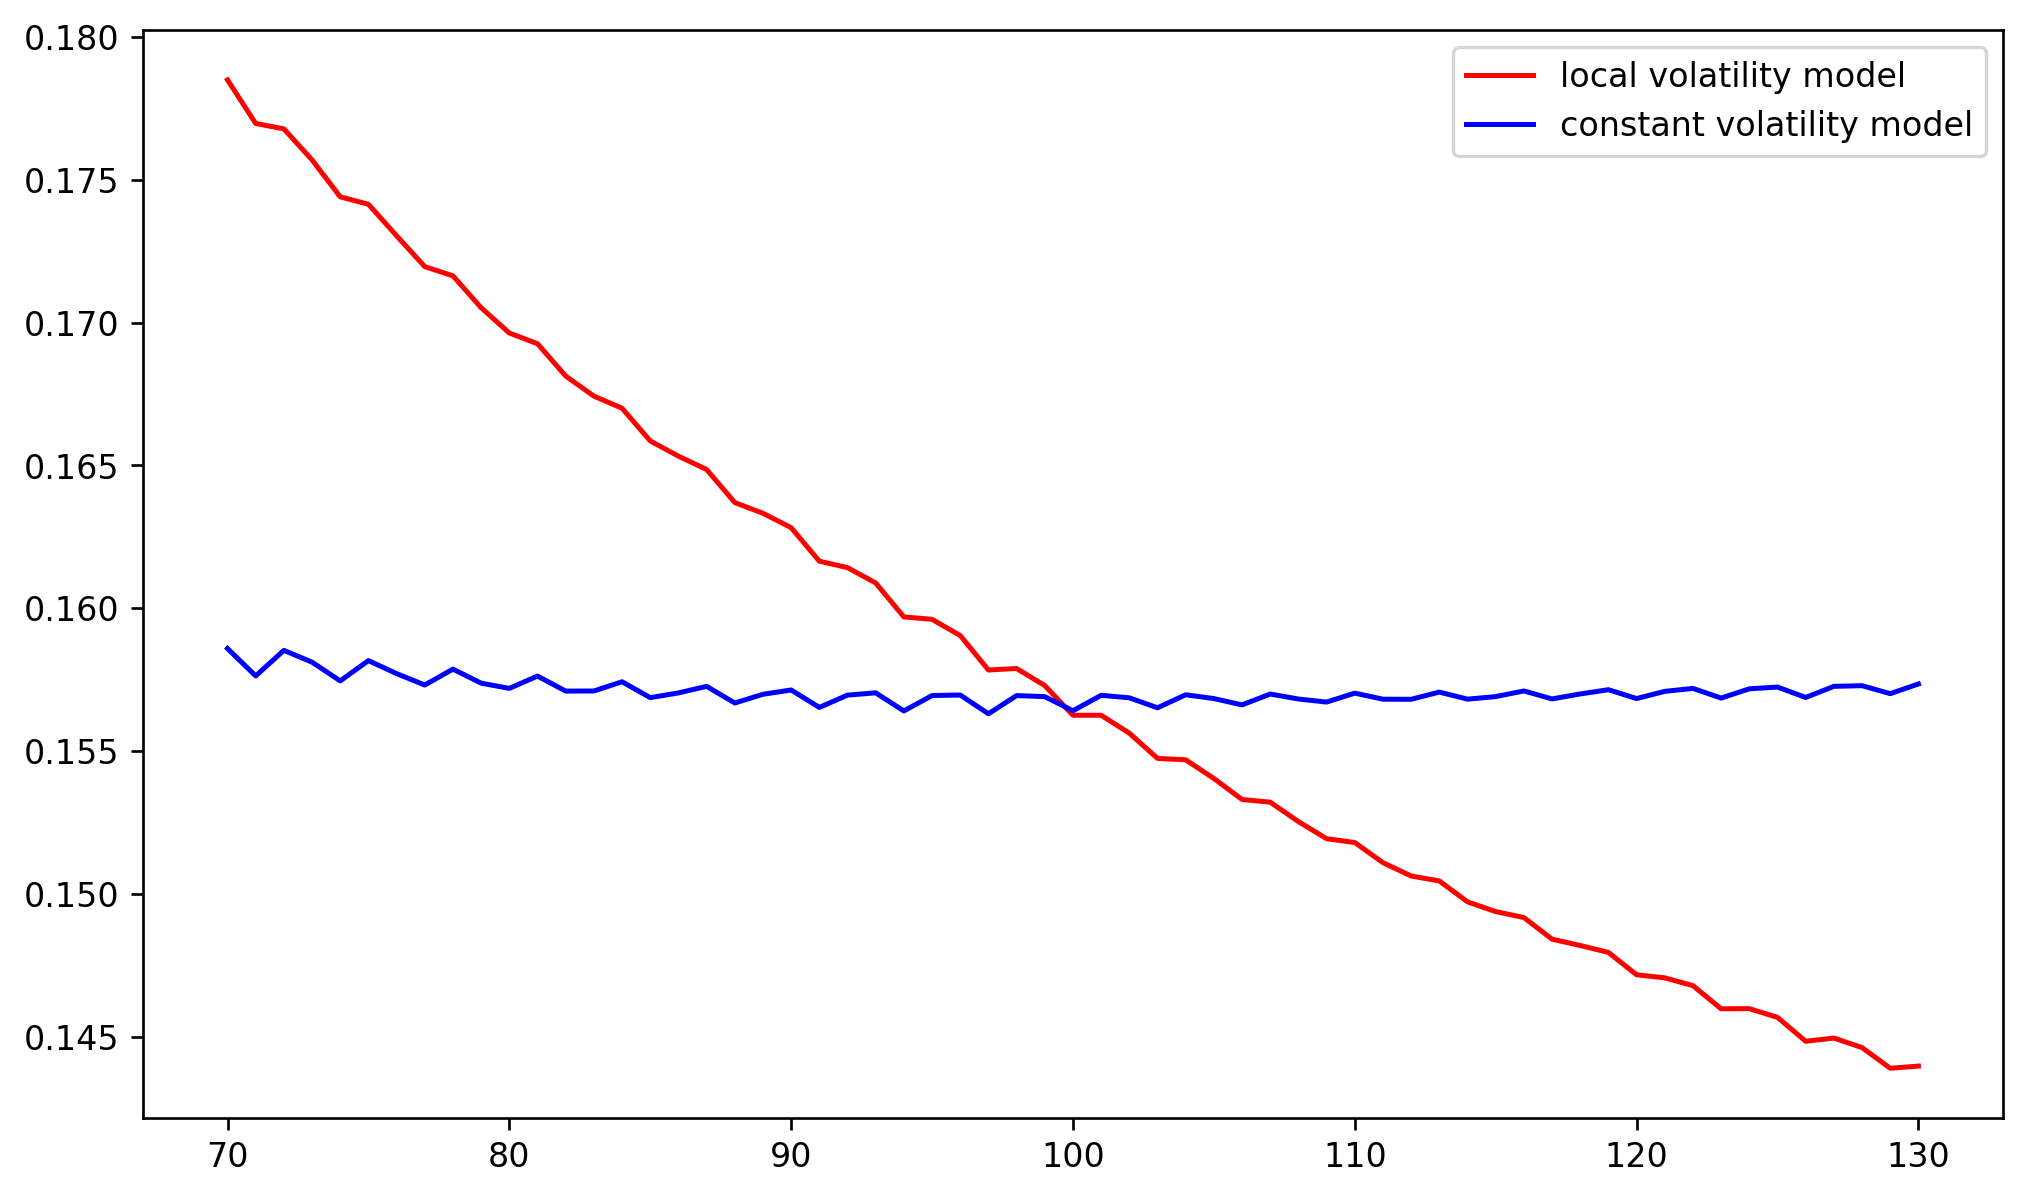

In [22]:
plt.plot(strikes,vol,"r-",label = "local volatility model")
plt.plot(strikes,vol_,"b-",label = "constant volatility model")
plt.legend()
plt.savefig("./Q2.2.b.jpg")

From the graph, we can see that the implied volatility is a decreasing function of the strike price, and the implied volatility corresponding to deep in-the-money call options is much higher than that of deep out-of-the-money call options. As stock prices and volatility usually exhibit negative correlation, when stock prices rise, volatility tends to decrease.

# 3.1.a

The down-and-in barrier put option with payoff
$$
\left(K-S_T\right)^{+} 1_{\left(L_T \leq B_{i n}\right)}
$$
where $L_t:=\inf _{0 \leq u \leq t} S_u$ is the running minimum of the stock price up to time $t$, and $B_{i n}$ is the knock-in level of the option.

By Feynman-Kac Theorem, the price $V$ of a down-and-in barrier put option must satisfy the following PDE:
$$
\begin{cases}
\frac{\partial V}{\partial \tau}=\frac{\psi^2(\tau, s) s^2}{2} \frac{\partial^2 V}{\partial s^2}+r s \frac{\partial V}{\partial s}-r V, & \tau<T \\ V(0, s)=\left(K-s\right)^{+} 1_{\left(s \leq B_{i n}\right)}, & \tau=0\\
V(\tau,s) = Put(s, K, r, \tau, \psi(\tau,s)),& \tau<T;s\leq B_{in}\\
V(\tau,s_{min}) = Ke^{-r\tau}-s_{min}& \tau<T\\
V(\tau,s_{max}) = 0& \tau<T
\end{cases}
$$

In [37]:
def cn_solver(N,M,r,strike,s_min = 10,s_max = 300,sigma = 0.157,constant = False):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    sol = np.maximum(s_axis-strike,0)
    
    # define auxiliary function/matrix
    a = 0.5*psi(t_axis,s_axis)**2 * s_axis**2 if not constant else 0.5*sigma**2 * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N+1,M+1,M+1))
    for i in range(N+1):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([A[i,j], B[i,j], C[i,j]])
  
    V = [sol]
    # solve numerically
    for i in range(1,N+1):
        sol_pre = np.matmul(np.eye(M+1)+0.5*L[i-1],sol)
        sol_pre[-1] = s_axis[-1] - strike * np.exp(-r*t_axis[i])
        sol_pre[0] = 0
        sol = TDMAsolver(np.diag(np.eye(M+1)-0.5*L[i],k=-1), np.diag(np.eye(M+1)-0.5*L[i]), np.diag(np.eye(M+1)-0.5*L[i],k=1),sol_pre)
        V.append(sol)
    return np.array(V)

def down_and_in(N,M,r,strike,level,s_min = 10,s_max = 300,sigma = 0.157,constant = False):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    mask = s_axis<=level
    sol = np.maximum(-(s_axis-strike)*mask.astype(int),0) 
    call = cn_solver(N,M,r,strike,s_min = 10,s_max = 300,constant = constant)
    
    # define auxiliary function/matrix
    a = 0.5*psi(t_axis,s_axis)**2 * s_axis**2 if not constant else 0.5*sigma**2 * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N+1,M+1,M+1))
    for i in range(N+1):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([A[i,j], B[i,j], C[i,j]])
    
    # solve numerically
    for i in range(1,N+1):
        sol_pre = np.matmul(np.eye(M+1)+0.5*L[i-1],sol)
        # modify to boundary condition 
        sol_pre[mask] = call[i,mask] - s_axis[mask] + strike * np.exp(-r*t_axis[i]) # put - call parity
        sol_pre[-1] = 0 
        sol = TDMAsolver(np.diag(np.eye(M+1)-0.5*L[i],k=-1), np.diag(np.eye(M+1)-0.5*L[i]), np.diag(np.eye(M+1)-0.5*L[i],k=1),sol_pre)
    return sol,s_axis

### Thereotical solutoin under BS model
$m_t^T=\min_{t\leq u \leq T}S_u$, $Bl_{put}$ is put option price under BS model.

$$
\delta_{\pm}^\tau(s)=\frac{1}{\sigma \sqrt{\tau}}\left(\log s+\left(r \pm \frac{\sigma^2}{2}\right) \tau\right)
$$

$$
\begin{aligned}
& \mathrm{e}^{-(T-t) r} \mathbb{E}^*\left[\left(K-S_T\right)^{+} \mathbb{1}_{\left\{m_t^T<B\right\}} \mid \mathcal{F}_t\right] \\
& =\mathbb{1}_{\left\{m_0^t \leqslant B\right\}} \mathrm{Bl}_{\text {put }}\left(S_t, K, r, T-t, \sigma\right)-S_t \mathbb{1}_{\left\{m_0^t>B\right\}} \Phi\left(-\delta_{+}^{T-t}\left(\frac{S_t}{B}\right)\right) \\
& +B \mathbb{1}_{\left\{m_0^t>B\right\}}\left(\frac{B}{S_t}\right)^{2 r / \sigma^2}\left(\Phi\left(\delta_{+}^{T-t}\left(\frac{B^2}{K S_t}\right)\right)-\Phi\left(\delta_{+}^{T-t}\left(\frac{B}{S_t}\right)\right)\right) \\
& +\mathrm{e}^{-(T-t) r} K \mathbb{1}_{\left\{m_0^t>B\right\}} \Phi\left(-\delta_{-}^{T-t}\left(\frac{S_t}{B}\right)\right) \\
& -\mathrm{e}^{-(T-t) r} K \mathbb{1}_{\left\{m_0^t>B\right\}}\left(\frac{S_t}{B}\right)^{1-2 r / \sigma^2}\left(\Phi\left(\delta_{-}^{T-t}\left(\frac{B^2}{K S_t}\right)\right)-\Phi\left(\delta_{-}^{T-t}\left(\frac{B}{S_t}\right)\right)\right) \text {, } \\
& 0 \leqslant t \leqslant T \\
&
\end{aligned}
$$

In our case, $t=0$

In [19]:
def BS_put(price,strike_price,r,sigma,T):
    d_positive = (np.log(price/strike_price)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_negative = d_positive - sigma*np.sqrt(T)
    return -price * norm.cdf(-d_positive) + np.exp(-r*T)*norm.cdf(-d_negative)*strike_price

def delta(sign,T,s,sigma,r):
    return 1/(sigma*np.sqrt(T)) * (np.log(s)+(r+sign*0.5*sigma**2)*T)

def BS_down_and_in(T,price,sigma,r,level,strike):
    term1 = BS_put(price,strike,r,sigma,T)*int(price<=level)
    term2 = -int(price>level)*price*norm.cdf(-delta(1,T,price/level,sigma,r))
    term3 = level * int(price>level) * (level/price)**(2*r/sigma**2)*(norm.cdf(delta(1,T,level**2/(strike*price),sigma,r))
                                                                     -norm.cdf(delta(1,T,level/price,sigma,r)))
    term4 = np.exp(-T*r)*strike*int(price>level)*norm.cdf(-delta(-1,T,price/level,sigma,r))
    term5 = -np.exp(-T*r)*strike*int(price>level)*(price/level)**(1-(2*r/sigma**2))*(norm.cdf(delta(-1,T,level**2/(strike*price),sigma,r))
                                                                                    -norm.cdf(delta(-1,T,level/price,sigma,r)))
    return term1+term2+term3+term4+term5

In [38]:
sigma = 0.157
price,strike = 100,100
stochastic_vol_price = []
constant_vol = []
BS = []
for level in tqdm([60,70,80,90]):
    BS.append(BS_down_and_in(T,price,sigma,r,level,strike))
    a,x = down_and_in(2500,200,r,strike,level)
    func = CubicSpline(x,a)
    stochastic_vol_price.append(func(price))
    a,x = down_and_in(2500,200,r,strike,level,constant = True)
    func = CubicSpline(x,a)
    constant_vol.append(func(price))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.20s/it]


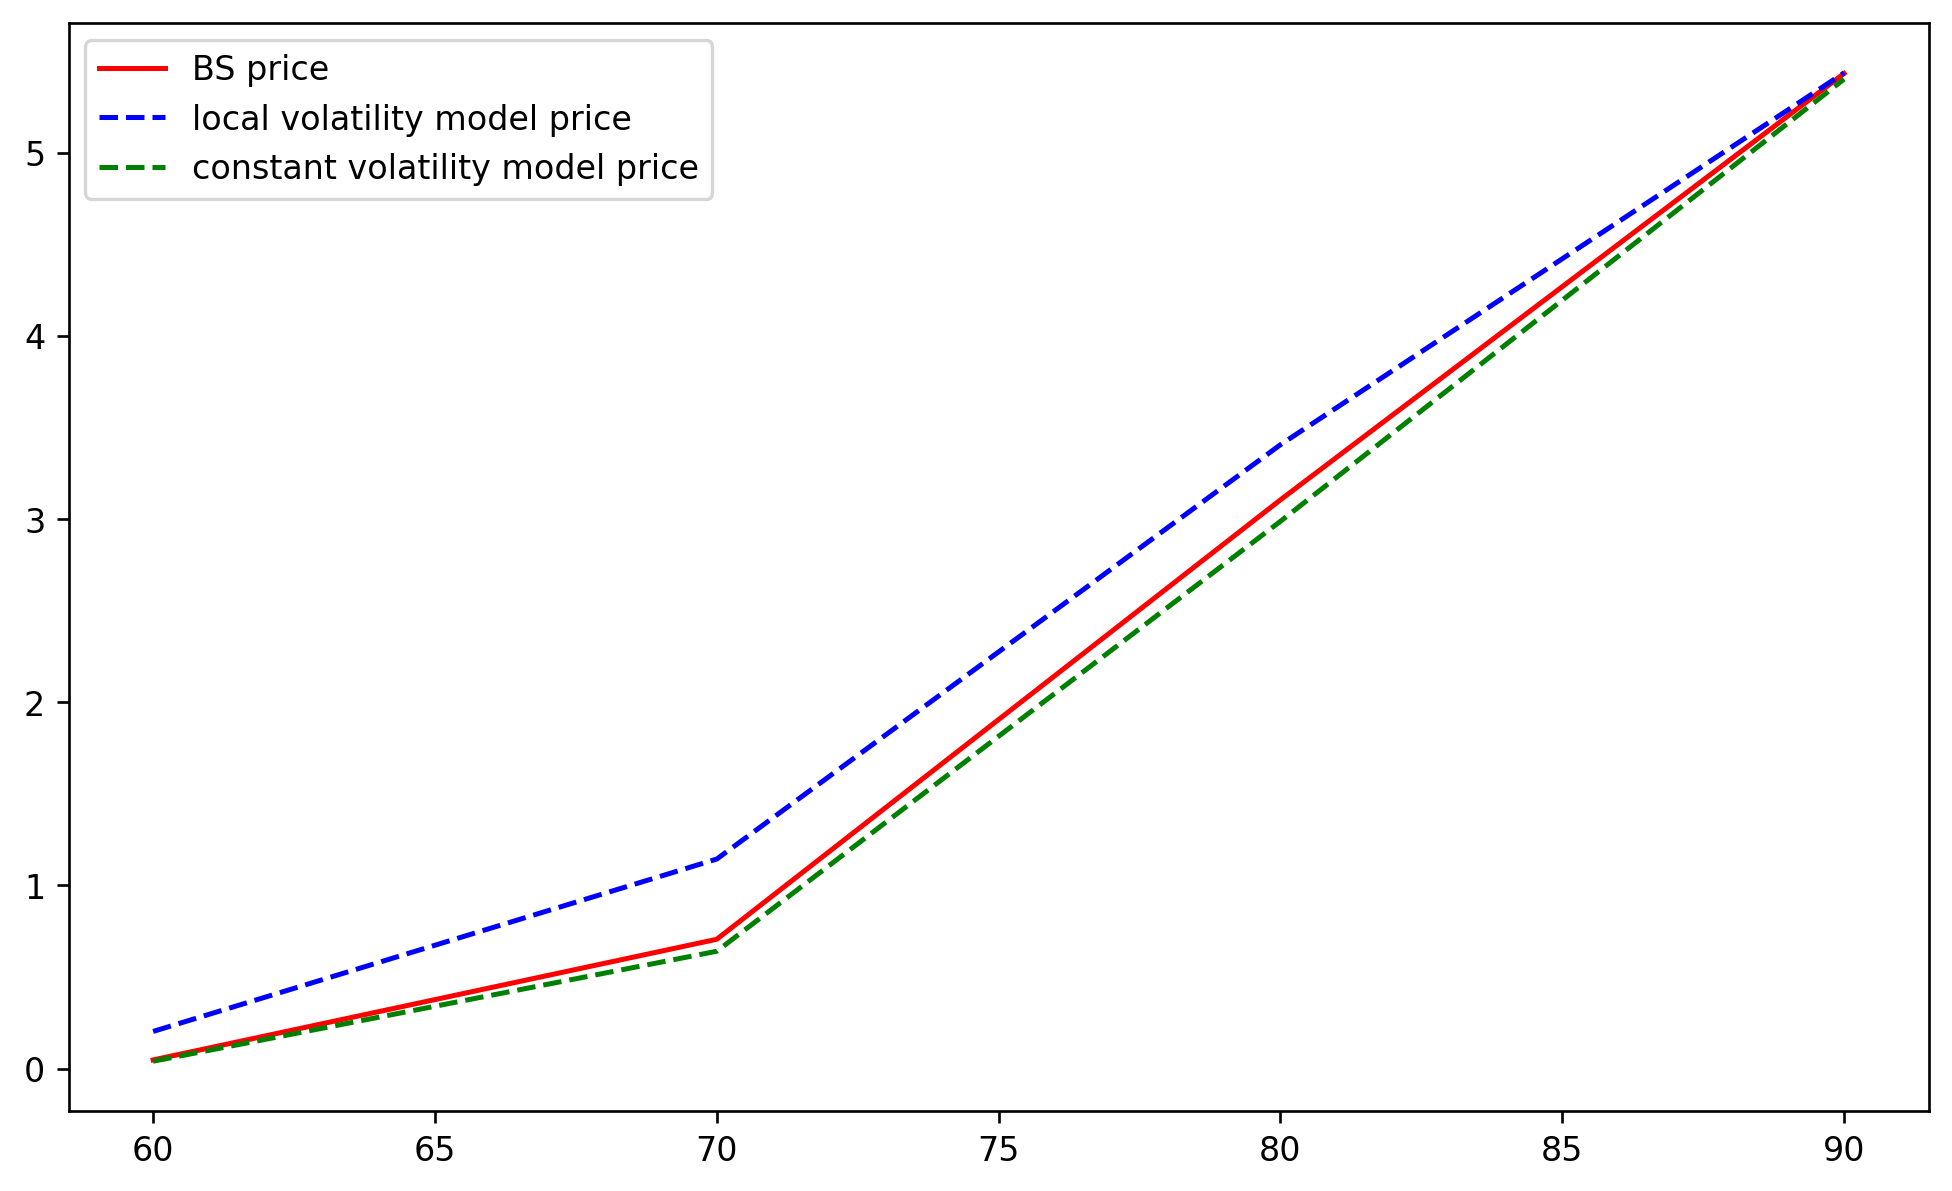

In [39]:
plt.plot([60,70,80,90],BS,"r-",label = "BS price")
plt.plot([60,70,80,90],stochastic_vol_price,"b--",label = "local volatility model price")
plt.plot([60,70,80,90],constant_vol,"g--",label = "constant volatility model price")
plt.legend()
# plt.savefig("./Q2.3.b.jpg")

In [33]:
def implied_vol(price, strike, r, T, C,level):
    obj_f = lambda sigma: BS_down_and_in(T,price,sigma,r,level,strike)-C
    root = brentq(obj_f,0.01,1)
    return root

In [61]:
for C,level in zip(stochastic_vol_price,[60,70,80,90]):
    print(implied_vol(price, strike, r, T, C,level))

0.18049992646109184
0.17066569575526433
0.16231544551071686
0.15707819744117618


# in-out-parity

$$
\left(K-S_T\right)^{+} 1_{\left(L_T \geq B_{i n}\right)}
$$



$$
\begin{cases}
\frac{\partial V}{\partial \tau}=\frac{\psi^2(\tau, s) s^2}{2} \frac{\partial^2 V}{\partial s^2}+r s \frac{\partial V}{\partial s}-r V, & \tau<T \\ V(0, s)=\left(K-s\right)^{+} 1_{\left(s \geq B_{i n}\right)}, & \tau=0\\
V(\tau,s) = 0& \tau<T;s\leq B_{in}\\
V(\tau,s_{min}) = 0& \tau<T\\
V(\tau,s_{max}) = 0& \tau<T
\end{cases}
$$

In [40]:
def down_and_out(N,M,r,strike,level,s_min,s_max = 300,sigma = 0.157,constant = False):
    dt = T/N
    dx = (s_max-s_min) / M
    sol = np.zeros(M+1)
    s_axis = np.linspace(s_min,s_max,M+1)
    t_axis = np.linspace(0,T,N+1)
    r_ = np.ones((N+1,M+1)) * r
    
    # Boundary condition
    sol = np.maximum(-(s_axis-strike),0) 
    
    # define auxiliary function/matrix
    a = 0.5*psi(t_axis,s_axis)**2 * s_axis**2 if not constant else 0.5*sigma**2 * s_axis**2
    b = r_ * s_axis
    c = r_
    
    A = dt/(dx**2) * a - dt/(2*dx) * b
    B = -2*dt/(dx**2) * a - dt*c
    C = dt/(dx**2) * a + dt/(2*dx) * b
    
    L = np.zeros((N+1,M+1,M+1))
    for i in range(N+1):
        for j in range(1,M):
            L[i,j,j-1:j+2] = np.array([A[i,j], B[i,j], C[i,j]])
    
    # solve numerically
    for i in range(1,N+1):
        sol_pre = np.matmul(np.eye(M+1)+0.5*L[i-1],sol)
        # modify to boundary condition 
        sol_pre[-1] = 0 
        sol_pre[0] = 0
        sol = TDMAsolver(np.diag(np.eye(M+1)-0.5*L[i],k=-1), np.diag(np.eye(M+1)-0.5*L[i]), np.diag(np.eye(M+1)-0.5*L[i],k=1),sol_pre)
    return sol,s_axis

In [41]:
def put(N,M,r,strike,level,s_min=10,s_max = 300,sigma = 0.157,constant = False):
    call = cn_solver(N,M,r,strike,constant = constant)[-1]
    s_axis = np.linspace(s_min,s_max,M+1)
    put = call - s_axis + strike * np.exp(-r) # put - call parity
    return put,s_axis

In [42]:
price,strike = 100,100
stochastic_vol_price = []
constant_vol = []
BS = []
sigma = 0.157
for level in tqdm(aa:=[60,70,80,90]):
    BS.append(BS_down_and_in(T,price,sigma,r,level,strike))
    y,x = put(2500,200,r,strike,level)
    put_ = CubicSpline(x,y)
    
    a,x = down_and_out(2500,200,r,strike,level,level)
    func = CubicSpline(x,a)
    stochastic_vol_price.append(put_(price)-func(price))
    
    a,x = down_and_out(2500,200,r,strike,level,level,constant = True)
    func = CubicSpline(x,a)
    constant_vol.append(put_(price)-func(price))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.41s/it]


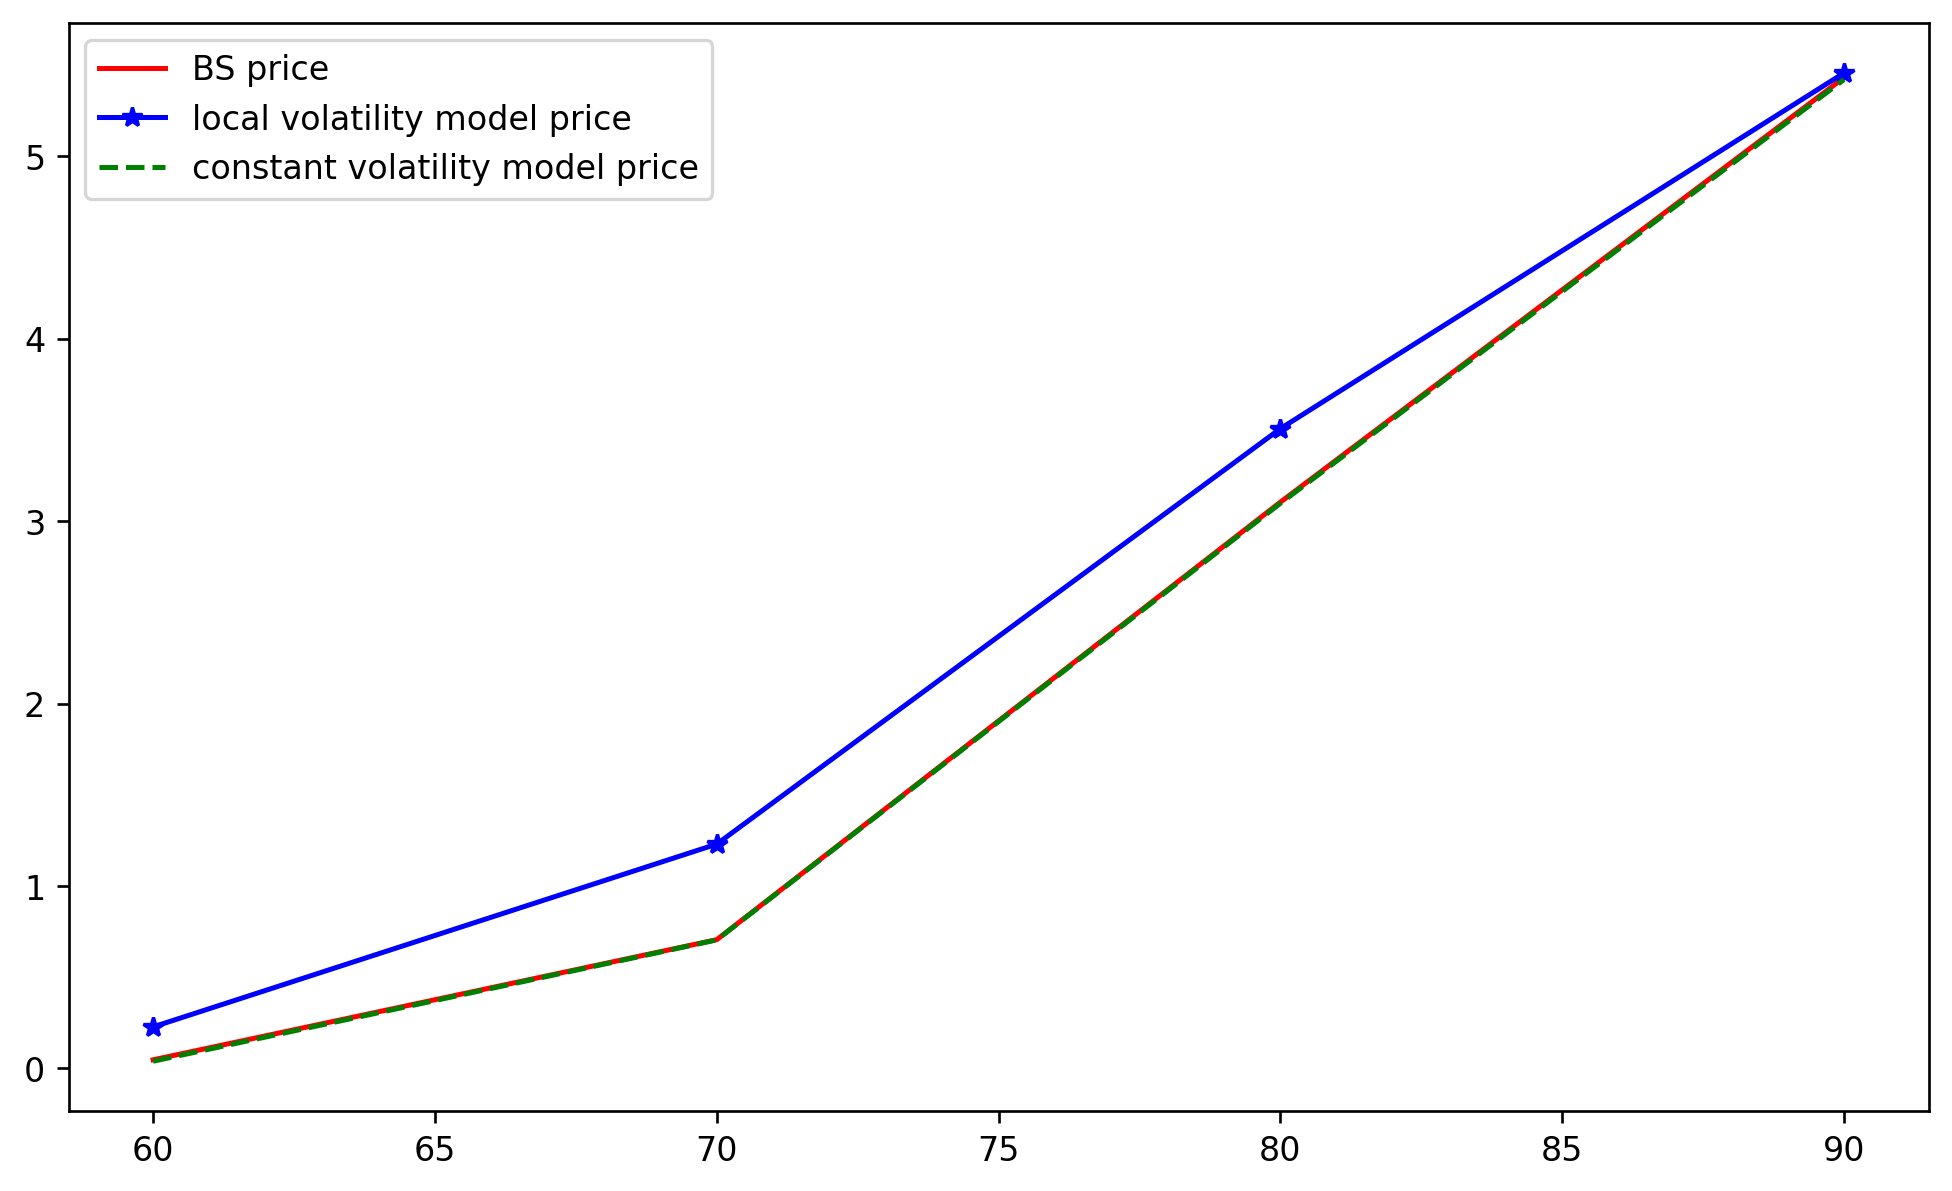

In [43]:
plt.plot(aa,BS,"r-",label = "BS price")
plt.plot(aa,stochastic_vol_price,"b-*",label = "local volatility model price")
plt.plot(aa,constant_vol,"g--",label = "constant volatility model price")
plt.legend()
plt.savefig("./Q2.3.b.jpg")

In [50]:
vv = []
for C,level in zip(stochastic_vol_price,[60,70,80,90]):
    vv.append(implied_vol(price, strike, r, T, C,level))

In [44]:
data = {'Local volatility': stochastic_vol_price,
        'Constant volatility': constant_vol,
        'Constant volatility(Theoretical price)': BS}
df = pd.DataFrame(data)
df.index = [60,70,80,90]
df.index.name = "Barrier"

In [45]:
df

,Local volatility,Constant volatility,Constant volatility(Theoretical price)
Barrier,,,
60,0.227615,0.039294,0.047244
70,1.229601,0.704472,0.705837
80,3.507021,3.097747,3.104249
90,5.457144,5.420689,5.431394


In [46]:
print(df.style.to_latex())

\begin{tabular}{lrrr}
 & Local volatility & Constant volatility & Constant volatility(Theoretical price) \\
Barrier &  &  &  \\
60 & 0.227615 & 0.039294 & 0.047244 \\
70 & 1.229601 & 0.704472 & 0.705837 \\
80 & 3.507021 & 3.097747 & 3.104249 \\
90 & 5.457144 & 5.420689 & 5.431394 \\
\end{tabular}



In [51]:
imp = pd.DataFrame({"Implied volatility":vv})
imp.index = [60,70,80,90]
imp.index.name = "Barrier"

In [52]:
imp

,Implied volatility
Barrier,
60,0.182818
70,0.173016
80,0.164107
90,0.157582


In [53]:
print(imp.style.to_latex())

\begin{tabular}{lr}
 & Implied volatility \\
Barrier &  \\
60 & 0.182818 \\
70 & 0.173016 \\
80 & 0.164107 \\
90 & 0.157582 \\
\end{tabular}

